<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/KAN_vs_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pykan

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from kan import KAN, create_dataset

## Create dataset

In [5]:
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2).float()
dataset = create_dataset(f, n_var=2)
dataset['train_input'] = dataset['train_input'].float()
dataset['train_label'] = dataset['train_label'].float()

## Create metrics

In [11]:
def mse(y_true, y_pred):
    return ((y_pred - y_true) ** 2).mean()

def rmse(y_true, y_pred):
    return torch.sqrt(mse(y_true, y_pred))


def evaluate_model(model, dataset):
    with torch.no_grad():
        outputs = model(dataset['test_input'])
        mse_value = mse(dataset['test_label'], outputs).item()
        rmse_value = rmse(dataset['test_label'], outputs).item()
    return mse_value, rmse_value

In [39]:
def train_mlp(model, optimizer, epochs=20, dataset=dataset):
    criterion = nn.MSELoss()
    mse_history = []
    rmse_history = []

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            outputs = model(dataset['train_input'])
            loss = criterion(outputs, dataset['train_label'])
            loss.backward()
            return loss

        optimizer.step(closure)
        with torch.no_grad():
            outputs = model(dataset['train_input'])
            current_mse = mse(dataset['train_label'], outputs)
            current_rmse = rmse(dataset['train_label'], outputs)

        mse_history.append(current_mse.item())
        rmse_history.append(current_rmse.item())

    return mse_history, rmse_history, model


## Create KAN model

In [ ]:
kan_model = KAN(width=[2, 5, 1], grid=5, k=3, seed=0)
kan_optimizer = optim.LBFGS(kan_model.parameters(), lr=1)
kan_model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)

## Create MLP

Let's train 3 MLPs and train them for 20, 200 and 2k epochs

In [54]:

mlp_models = []

epochs_list = [20, 200, 2000]
for epochs in epochs_list:
    mlp_model = nn.Sequential(
                              nn.Linear(2, 5),
                              nn.ReLU(),
                              nn.Linear(5, 5),
                              nn.ReLU(),
                              nn.Linear(5, 1))
    for param in mlp_model.parameters():
        param.data = param.data.float()
    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)
    mse_hist, rmse_hist, mlp_model = train_mlp(mlp_model, mlp_optimizer, epochs=epochs)
    mlp_models.append(mlp_model)

## Create predictions

In [50]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

true_values = f(xy).reshape(100, 100).numpy()

with torch.no_grad():
    kan_predictions = kan_model(xy).reshape(100, 100).numpy()
    mlp_predictions = mlp_model(xy).reshape(100, 100).numpy()


## Plot predictions

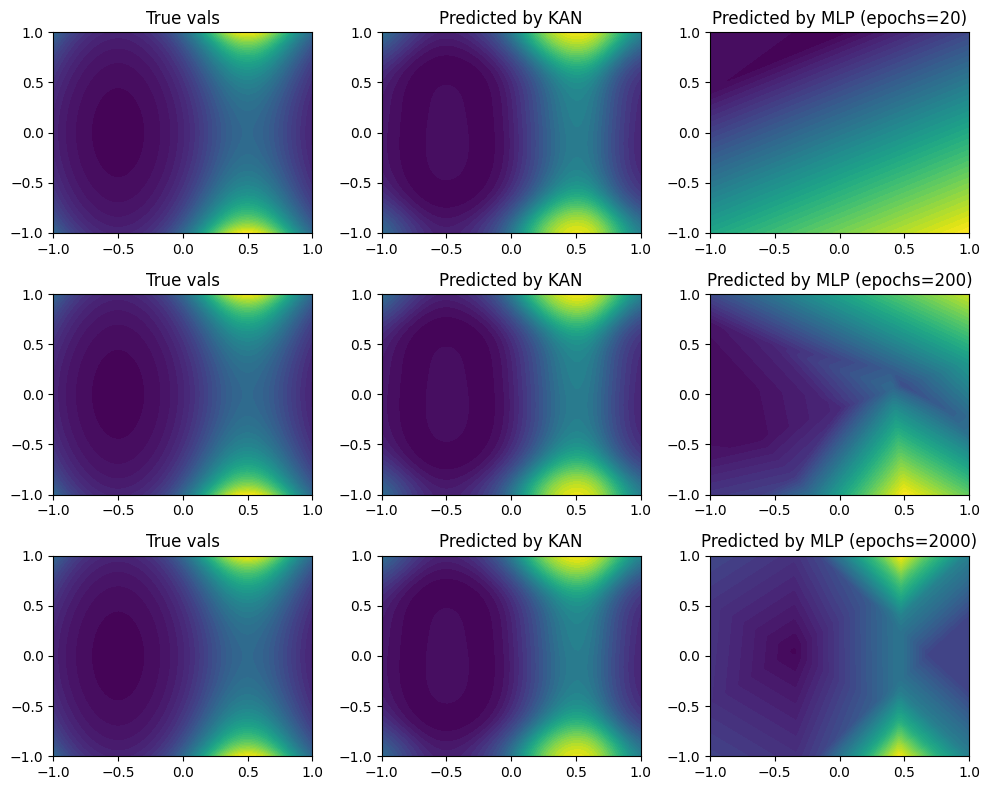

In [59]:
fig, axs = plt.subplots(len(epochs_list), 3, figsize=(10, 2*(len(epochs_list) + 1)))

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
xy = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=-1), dtype=torch.float32)

true_values = f(xy).reshape(100, 100).numpy()

with torch.no_grad():
    kan_predictions = kan_model(xy).reshape(100, 100).numpy()
    for i, mlp_model in enumerate(mlp_models):
        mlp_predictions = mlp_model(xy).reshape(100, 100).numpy()
        axs[i, 0].contourf(X, Y, true_values, levels=50, cmap='viridis')
        axs[i, 0].set_title('True vals')
        axs[i, 1].contourf(X, Y, kan_predictions, levels=50, cmap='viridis')
        axs[i, 1].set_title('Predicted by KAN')
        axs[i, 2].contourf(X, Y, mlp_predictions, levels=50, cmap='viridis')
        axs[i, 2].set_title(f'Predicted by MLP (epochs={epochs_list[i]})')

plt.tight_layout()
plt.show()

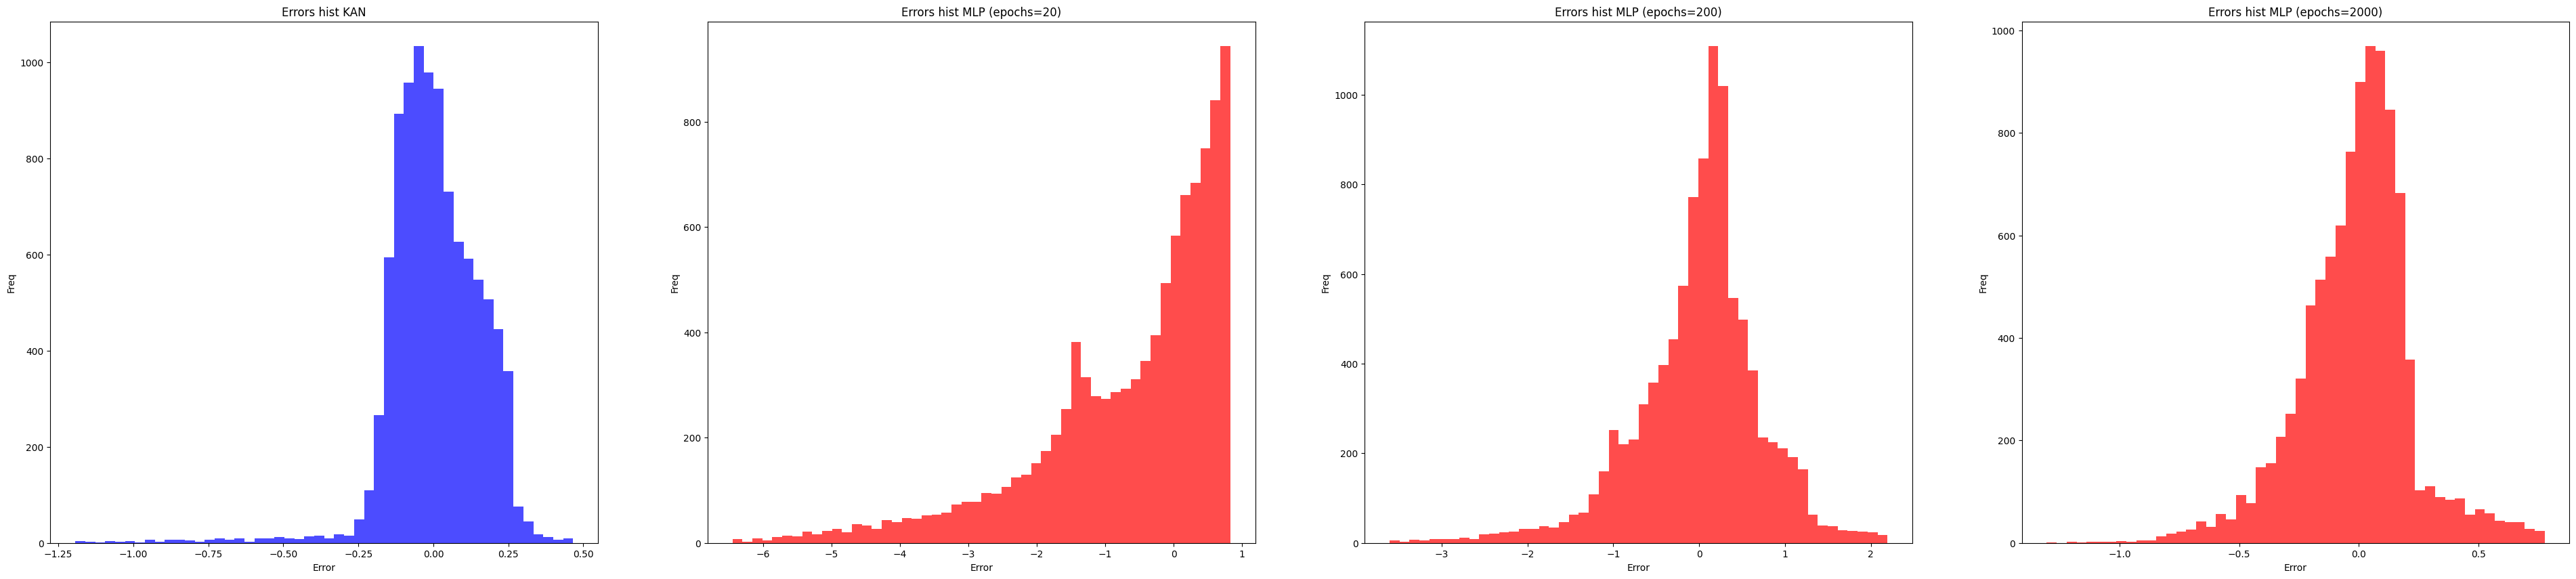

In [64]:
kan_errors = (kan_predictions - true_values).ravel()

mlp_errors_list = []
for mlp_model in mlp_models:
    mlp_predictions = mlp_model(xy).reshape(100, 100).detach().numpy()
    mlp_errors = (mlp_predictions - true_values).ravel()
    mlp_errors_list.append(mlp_errors)

fig, axs = plt.subplots(1, len(epochs_list) + 1, figsize=(12*(len(epochs_list) + 1), 10))

axs[0].hist(kan_errors, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Errors hist KAN')
axs[0].set_xlabel('Error')
axs[0].set_ylabel('Freq')

for i, mlp_errors in enumerate(mlp_errors_list):
    axs[i+1].hist(mlp_errors, bins=50, color='red', alpha=0.7)
    axs[i+1].set_title(f'Errors hist MLP (epochs={epochs_list[i]})')
    axs[i+1].set_xlabel('Error')
    axs[i+1].set_ylabel('Freq')

plt.show()


## Another experiment

In [27]:
test_dataset = create_dataset(f, n_var=2)
test_dataset['test_input'] = test_dataset['test_input'].float()
test_dataset['test_label'] = test_dataset['test_label'].float()

### Evaluate RMSE

KAN Model:
RMSE on test set: 0.13341194983308796

MLP Models:
RMSE on test set (MLP, epochs=20): 1.466269612312317
RMSE on test set (MLP, epochs=200): 0.71242755651474
RMSE on test set (MLP, epochs=2000): 0.23363152146339417


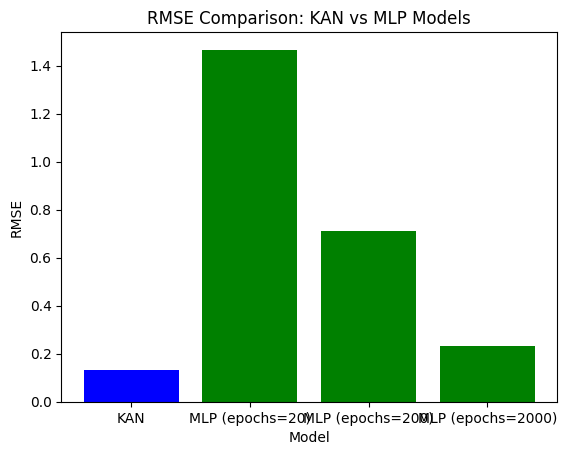

In [73]:
kan_rmse = evaluate_model(kan_model, test_dataset)[1]

mlp_rmse_list = []
for mlp_model in mlp_models:
    mlp_rmse = evaluate_model(mlp_model, test_dataset)[1]
    mlp_rmse_list.append(mlp_rmse)

print("KAN Model:")
print("RMSE on test set:", kan_rmse)

print("\nMLP Models:")
for i, mlp_rmse in enumerate(mlp_rmse_list):
    print(f"RMSE on test set (MLP, epochs={epochs_list[i]}):", mlp_rmse)

# Visualize RMSE for each model compared to KAN
models = ['KAN'] + [f'MLP (epochs={epochs_list[i]})' for i in range(len(epochs_list))]
rmse_values = [kan_rmse] + mlp_rmse_list

plt.bar(models, rmse_values, color=['blue'] + ['green'] * len(epochs_list))
plt.title('RMSE Comparison: KAN vs MLP Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()


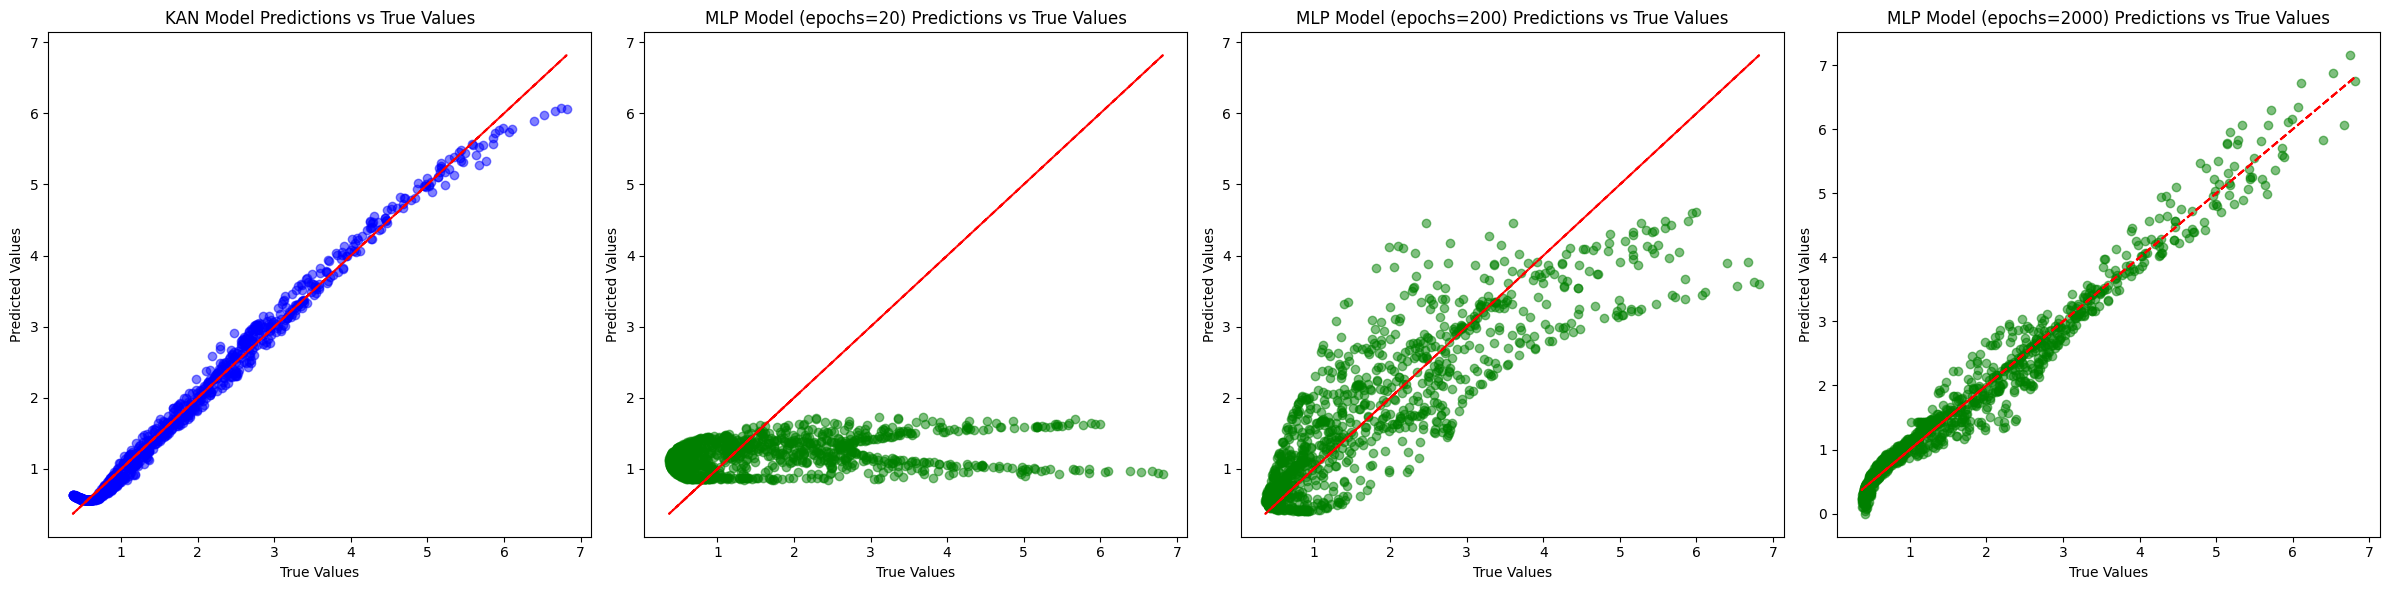

In [72]:
kan_mse, kan_rmse = evaluate_model(kan_model, test_dataset)
mlp_mse, mlp_rmse = evaluate_model(mlp_model, test_dataset)

fig, axs = plt.subplots(1, len(epochs_list) + 1, figsize=(6 * (len(epochs_list) + 1), 6))

kan_test_predictions = kan_model(test_dataset['test_input']).detach().numpy()
axs[0].scatter(test_dataset['test_label'], kan_test_predictions, color='blue', alpha=0.5)
axs[0].plot(test_dataset['test_label'], test_dataset['test_label'], color='red', linestyle='--')
axs[0].set_title('KAN Model Predictions vs True Values')
axs[0].set_xlabel('True Values')
axs[0].set_ylabel('Predicted Values')

for i, mlp_model in enumerate(mlp_models):
    mlp_test_predictions = mlp_model(test_dataset['test_input']).detach().numpy()
    axs[i+1].scatter(test_dataset['test_label'], mlp_test_predictions, color='green', alpha=0.5)
    axs[i+1].plot(test_dataset['test_label'], test_dataset['test_label'], color='red', linestyle='--')
    axs[i+1].set_title(f'MLP Model (epochs={epochs_list[i]}) Predictions vs True Values')
    axs[i+1].set_xlabel('True Values')
    axs[i+1].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()



Nuff said